#### Part1. 기본학습 - AI 핵심이론 및 활용     
    chp10 - 모델 튜닝 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

---
#### 대표적인 하이퍼 파라미터 자동튜닝 기법  
- (1) GridSearchCV : 모든 파라미터 값의 조합에 대해 모델성능 비교 
- (2) RandomizedSearchCV : 랜덤 조합이 선택, 파라미터 탐색범위가 넓거나, 연속적인 값을 탐색해야 하는 경우 효율적 
- 사이킷런의 model_selection 서브 패키지에 포함  
- 사용자가 튜닝하려는 하이퍼 파라미터 값들을 리스트로 지정 -> 딕셔너리 자료형 구성 -> (1) 또는 (2)의 클래스 객체 생성 -> estimator 객채 훈련/튜닝
---

In [2]:
# MNIST 데이터셋 로드
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()  # 데이터를 텐서로 변환
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

# 학습 및 테스트 데이터를 분리
x_train = train_data.data[:6000]
y_train = train_data.targets[:6000]
x_test = test_data.data[:1000]
y_test = test_data.targets[:1000]

print('원본데이터 형태 =', x_train.shape, y_train.shape, x_test.shape, y_test.shape)

# 이미지 데이터는 3차원 행렬 -> 2차원으로 변경 필요
X_train = x_train.reshape(-1, 784)
X_test = x_test.reshape(-1, 784)

print('변경된 데이터 형태 =', X_train.shape, X_test.shape) 

원본데이터 형태 = torch.Size([6000, 28, 28]) torch.Size([6000]) torch.Size([1000, 28, 28]) torch.Size([1000])
변경된 데이터 형태 = torch.Size([6000, 784]) torch.Size([1000, 784])


#### GridSearchCV

In [3]:
# Random Forrest with GridSearchCV (Grid Search Cross Validation)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

estimator = RandomForestClassifier()
param_grid = {
    'max_depth': [3, 5, 10, None],           # 트리의 최대 깊이의 경우의 수
    'n_estimators': [10, 100, 200],          # 앙상블에 포함된 트리 갯수의 경우의 수
    'max_features': [1, 2, 3],               # 각 트리에 사용되는 최대 특성 갯수
    'min_samples_leaf': [1, 2, 3],           # 리프 노드(최말단 노드)에 포함될 샘플의 최소 갯수
    'min_samples_split': [2, 5, 10]          # 트리가 분할되기 위한 최소 샘플 갯수 (1은 제거)
}

gs_cv = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3
)

model = gs_cv.fit(X_train, y_train)

In [4]:
## Best parameters & Model score
print('Best parameters = ', model.best_params_)
print('Best score = ', model.best_score_)

Best parameters =  {'max_depth': None, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best score =  0.9313333333333333


In [5]:
## test data에 적용 후 모델성능 
clf = model.best_estimator_
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.924

#### RandomSearchCV

In [6]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint 

estimator = RandomForestClassifier()
param_distributions = {'max_depth': list(np.arange(3,13,step=3)) + [None],    ## 트리의 최대 깊이(3, 6, 9, 12, 무제한)
                       'n_estimators': np.arange(10,320,step=100),            ## 트리 갯수(10, 110, 210, 310)
                       'max_features': randint(1,7),                          ## 각 트리에 사용할 최대 특성 갯수(랜덤으로 [1, 6] 범위 선택)
                       'criterion': ['gini', 'entropy'],                      ## 트리 분할 기준(gini 또는 entropy)
                       'min_samples_leaf': randint(1,4),                      ## 리프 노드(말단 노드)에 포함될 최소 샘플 갯수(랜덤으로 [1, 3] 범위 선택) 
                       'min_samples_split': np.arange(2,8, step=2)            ## 트리가 분할되기 위한 최소 샘플 갯수(2, 4, 6)
                       }

rs_cv = RandomizedSearchCV(estimator=estimator, 
                           param_distributions=param_distributions,           ## 하이퍼파라미터 범위
                           n_iter = 10,                                       ## 랜덤으로 10개의 하이퍼파라미터 조합을 시도
                           scoring='accuracy',                                ## 평가 기준을 정확도로 설정
                           n_jobs = 1,                                        ## 1코어로 실행 
                           refit=True,                                        ## best 하이퍼파라미터 조합으로 모델 재학습
                           cv=3                                               ## 3-폴드 교차 검증
                           )

model = rs_cv.fit(X_train, y_train)

In [7]:
## Best parameters & Model score
print('Best parameters = ', model.best_params_)
print('Best score = ', model.best_score_)

## test data에 적용 후 모델성능 
clf = model.best_estimator_
clf.fit(X_train, y_train)
print('Test score = ', clf.score(X_test, y_test))

Best parameters =  {'criterion': 'entropy', 'max_depth': None, 'max_features': 5, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 10}
Best score =  0.8609999999999999
Test score =  0.829


---
#### 실습1. [회귀] 항공권 가격예측 모델 

In [8]:
# data 
cdf = pd.read_csv('data/Clean_Dataset.csv')
cdf = cdf[:5000]
cdf.drop('Unnamed: 0', axis=1, inplace=True)
cdf.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [9]:
display(cdf.describe(include='all'))    ## 변수들 확인 
cdf.isnull().sum()                      ## 결측치 확인

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
count,5000,5000,5000,5000,5000,5000,5000,5000,5000.000000,5000.000000,5000.000000
unique,6,222,1,6,3,6,1,1,NaN,NaN,NaN
top,Vistara,UK-819,Delhi,Evening,one,Night,Mumbai,Economy,NaN,NaN,NaN
freq,1496,90,5000,1391,3619,1702,5000,5000,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.665682,14.216800,7589.786600
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.247512,7.109536,4476.362204
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,1.000000,2409.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.330000,8.000000,4678.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.670000,14.000000,5955.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.080000,20.000000,10549.000000


airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

<Axes: xlabel='airline', ylabel='price'>

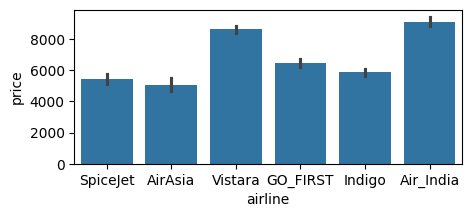

In [10]:
# airline 변수를 모델에 포함시켜야 할까? (가격과 연관성이 있는지?)
plt.figure(figsize=(5,2))
sns.barplot(data=cdf, x='airline', y='price')

In [11]:
# flight 변수를 모델에 포함시켜야 할까? (가격과 연관성이 있는지?)
## 배경지식 : 편명(flight)는 각 항공사마다 국내선/국제선/사업지역에 따라 부여되는 코드체계 
## 가격 예측과 별 상관없을 것으로 판단됨 
cdf.drop('flight', axis=1, inplace=True)
cdf.head(2)

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953


In [12]:
# one-hot encoding 
dummies_cdf = pd.get_dummies(cdf, 
                             columns=['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class'], 
                             drop_first=True
                             )
print(dummies_cdf.shape)
dummies_cdf.head(2)

(5000, 20)


,duration,days_left,price,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,departure_time_Early_Morning,departure_time_Evening,departure_time_Late_Night,departure_time_Morning,departure_time_Night,stops_two_or_more,stops_zero,arrival_time_Early_Morning,arrival_time_Evening,arrival_time_Late_Night,arrival_time_Morning,arrival_time_Night
0,2.17,1,5953,False,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,True
1,2.33,1,5953,False,False,False,True,False,True,False,False,False,False,False,True,False,False,False,True,False


In [13]:
# traing datasets 
y = dummies_cdf.price
x = dummies_cdf.drop('price', axis=1)
print(x.shape, y.shape)

(5000, 19) (5000,)


In [14]:
# 7 modeling 
#!pip install xgboost 
#!pip install lightgbm

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split

lr = LinearRegression()
dtr = DecisionTreeRegressor(random_state=42)
rfr = RandomForestRegressor(random_state=42)
gbr = GradientBoostingRegressor(random_state=42)
etr = ExtraTreesRegressor(n_jobs=-1, random_state=42)
xgbr = XGBRegressor(n_jobs=-1, random_state=42)
lgbmr = LGBMRegressor(n_jobs=-1, random_state=42)

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=42)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(3500, 19) (3500,) (1500, 19) (1500,)


In [15]:
# training 
lr.fit(x_train, y_train)
dtr.fit(x_train, y_train)
rfr.fit(x_train, y_train)
gbr.fit(x_train, y_train)
etr.fit(x_train, y_train)
xgbr.fit(x_train, y_train)
lgbmr.fit(x_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 231
[LightGBM] [Info] Number of data points in the train set: 3500, number of used features: 19
[LightGBM] [Info] Start training from score 7569.883429


LGBMRegressor(n_jobs=-1, random_state=42)

In [16]:
# 평가 
from sklearn.metrics import r2_score, root_mean_squared_error 
models = [lr, dtr, rfr, gbr, etr, xgbr, lgbmr]
r2_score_list = []
rmse_score_list = []

for model in models: 
    pred = model.predict(x_test)
    r2_score_list.append(r2_score(y_test, pred))
    rmse_score_list.append(root_mean_squared_error(y_test, pred))

r2_score_df = pd.DataFrame([r2_score_list, rmse_score_list], 
                           columns=['lr', 'dtr', 'rfr', 'gbr', 'etr', 'xgbr', 'lgbmr'], 
                           index=['r2', 'rmse']
                           )
r2_score_df

,lr,dtr,rfr,gbr,etr,xgbr,lgbmr
r2,0.630559,0.643057,0.796723,0.785569,0.714658,0.797469,0.808824
rmse,2691.022061,2645.114267,1996.133032,2050.164963,2364.981237,1992.463855,1935.804688


In [17]:
# best model인 lgbmr에 대해, 파라미터 튜닝 (GridSearchCV)
from sklearn.model_selection import GridSearchCV
params = {'learning_rate': [0.1, 0.01, 0.003], 
          'colsample_bytree':[0.5, 0.7], 
          'max_depth':[20,30,40] 
          }

cv_lgbmr = GridSearchCV(estimator=lgbmr, 
                        param_grid=params,                         
                        cv=5, verbose=1
                        )

cv_lgbmr.fit(x_train, y_train)

print('beat parameters = ', cv_lgbmr.best_params_)
print('beat score = ', cv_lgbmr.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 227
[LightGBM] [Info] Number of data points in the train set: 2800, number of used features: 18
[LightGBM] [Info] Start training from score 7554.416429
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

In [23]:
# beat parameters 적용하여 모델 재실행 
best_lgbmr = LGBMRegressor(max_depth=20, 
                           num_leaves=128,
                           learning_rate=0.1, 
                           colsample_bytree=0.7, 
                           n_jobs=-1, 
                           random_state=42
                           )

best_lgbmr.fit(x_train, y_train)

b_pred = best_lgbmr.predict(x_test)
print('r2_score = ', r2_score(y_test, b_pred))
print('rmse = ', root_mean_squared_error(y_test, b_pred))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 231
[LightGBM] [Info] Number of data points in the train set: 3500, number of used features: 19
[LightGBM] [Info] Start training from score 7569.883429
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

#### GridSearchCV 적용결과 
- 기존모델 vs. 최적모델 r2_score : 0.808824 -> 0.812336
- 기존모델 vs. 최적모델 rmse : 1935.804688 -> 1917.939375

In [19]:
# best model인 lgbmr에 대해, 파라미터 튜닝 (RandomizedSearchCV)
from sklearn.model_selection import RandomizedSearchCV
params = {'learning_rate': [0.1, 0.01, 0.001], 
          'colsample_bytree':[0.5, 0.7], 
          'max_depth':[20,30,40] 
          }

cv_lgbmr = RandomizedSearchCV(estimator=lgbmr, 
                              param_distributions=params, 
                              n_iter=500, 
                              cv=5, verbose=1
                              )

cv_lgbmr.fit(x_train, y_train)

print('beat parameters = ', cv_lgbmr.best_params_)

c:\Users\Seoyeon\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 18 is smaller than n_iter=500. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 18 candidates, totalling 90 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 227
[LightGBM] [Info] Number of data points in the train set: 2800, number of used features: 18
[LightGBM] [Info] Start training from score 7554.416429
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

In [22]:
# beat parameters 적용하여 모델 재실행 
best_lgbmr = LGBMRegressor(max_depth=20, 
                           num_leaves=128,
                           learning_rate=0.1, 
                           colsample_bytree=0.7, 
                           n_jobs=-1, 
                           random_state=42
                           )

best_lgbmr.fit(x_train, y_train)

b_pred = best_lgbmr.predict(x_test)
print('r2_score = ', r2_score(y_test, b_pred))
print('rmse = ', root_mean_squared_error(y_test, b_pred))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 231
[LightGBM] [Info] Number of data points in the train set: 3500, number of used features: 19
[LightGBM] [Info] Start training from score 7569.883429
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

#### RandomizedCV 최적화 적용 결과 
- 기존모델 vs. 최적모델 r2_score : 0.808824 -> 0.812336
- 기존모델 vs. 최적모델 rmse : 1935.804688 -> 1917.939375
---

#### 실습2. [분류] 항공사 고객만족 여부 예측 

In [56]:
pd.set_option('display.max_columns', None)          ## None : 모든 열을 출력, 숫자를 지정하면 그만큼의 열을 출력함  
cdf = pd.read_csv('data/Invistico_Airline.csv')
cdf = cdf[:5000]
cdf.head(2)

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Female,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,2,2,4,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Male,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,3,0,2,2,3,4,4,4,2,3,2,310,305.0


In [57]:
# target = 'satisfaction' 분포확인 
print(cdf['satisfaction'].value_counts())
print('-'*100)
print(cdf['satisfaction'].value_counts(normalize=True))

satisfaction
satisfied       2869
dissatisfied    2131
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
satisfaction
satisfied       0.5738
dissatisfied    0.4262
Name: proportion, dtype: float64


In [59]:
# 결측치 확인 
print(cdf.isnull().sum()) 

satisfaction                          0
Gender                                0
Customer Type                         0
Age                                   0
Type of Travel                        0
Class                                 0
Flight Distance                       0
Seat comfort                          0
Departure/Arrival time convenient     0
Food and drink                        0
Gate location                         0
Inflight wifi service                 0
Inflight entertainment                0
Online support                        0
Ease of Online booking                0
On-board service                      0
Leg room service                      0
Baggage handling                      0
Checkin service                       0
Cleanliness                           0
Online boarding                       0
Departure Delay in Minutes            0
Arrival Delay in Minutes             27
dtype: int64


In [60]:
# 결측치 = 27/5000로 매우 미미 --> 삭제 
cdf.dropna(axis=0, inplace=True)
display(cdf.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4973 entries, 0 to 4999
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   satisfaction                       4973 non-null   object 
 1   Gender                             4973 non-null   object 
 2   Customer Type                      4973 non-null   object 
 3   Age                                4973 non-null   int64  
 4   Type of Travel                     4973 non-null   object 
 5   Class                              4973 non-null   object 
 6   Flight Distance                    4973 non-null   int64  
 7   Seat comfort                       4973 non-null   int64  
 8   Departure/Arrival time convenient  4973 non-null   int64  
 9   Food and drink                     4973 non-null   int64  
 10  Gate location                      4973 non-null   int64  
 11  Inflight wifi service              4973 non-null   int64  
 1

None

In [61]:
# datasets 
y = cdf['satisfaction']
x = cdf.drop('satisfaction', axis=1)
print(x.shape, y.shape)

(4973, 22) (4973,)


In [62]:
# one-hot encoding 
x_gd = pd.get_dummies(x, 
                      columns=x.select_dtypes(include=['object']).columns, 
                      drop_first=False)
x_gd.head(2)

,Age,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Female,Gender_Male,Customer Type_Loyal Customer,Type of Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus
0,65,265,0,0,0,2,2,4,2,3,3,0,3,5,3,2,0,0.0,True,False,True,True,False,True,False
1,47,2464,0,0,0,3,0,2,2,3,4,4,4,2,3,2,310,305.0,False,True,True,True,True,False,False


In [63]:
# labeling 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

x_train, x_test, y_train, y_test = train_test_split(x_gd, y, stratify=y, test_size=0.2, random_state=42)
le = LabelEncoder()

le.fit(y_train)                      ## le가 y_train에 대해 학습 
le_y_train = le.transform(y_train)   ## le가 y_train에 대해 학습한 결과로 y_train을 변환 
le_y_test = le.transform(y_test)     ## le가 y_train에 대해 학습한 결과로 y_test을 변환  (le.fit_trasform(y_test)를 쓰면, y_test를 학습한 결과로 변환하므로 안됨)

print('labed data : ', le_y_train)
print('labed class :', le.classes_)

labed data :  [1 0 1 ... 1 0 1]
labed class : ['dissatisfied' 'satisfied']


In [64]:
# modeling 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBRFClassifier
from lightgbm import LGBMClassifier

lr = LogisticRegression()
dtc = DecisionTreeClassifier(random_state=1)
rfc = RandomForestClassifier(random_state=1)
gbc = GradientBoostingClassifier(random_state=1)
xgbc = XGBRFClassifier(random_state=1)
etc = ExtraTreesClassifier(random_state=1)
lgbmc = LGBMClassifier(random_state=1)

lr.fit(x_train, le_y_train)
dtc.fit(x_train, le_y_train)
rfc.fit(x_train, le_y_train)
gbc.fit(x_train, le_y_train)
xgbc.fit(x_train, le_y_train)
etc.fit(x_train, le_y_train)
lgbmc.fit(x_train, le_y_train)

# 순서대로 적용할 모델을 리스트에 저장하기
models = [lr, dtc, rfc, gbc, xgbc, etc, lgbmc]

# for문을 활용해 학습 모델 별 Score를 리스트에 저장하기
acc_train_list = []
acc_test_list = []
for model in models:
    acc_train_list.append(round(model.score(x_train, le_y_train),5))
    acc_test_list.append(round(model.score(x_test, le_y_test),5))

# 모델 별 정확도를 출력하기
for i in range(len(models)):
    print('학습모델 : ',models[i])
    print('train 정확도: ',acc_train_list[i])
    print('test 정확도: ',acc_test_list[i])
    print('----------------------------------')

c:\Users\Seoyeon\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2284, number of negative: 1694
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 673
[LightGBM] [Info] Number of data points in the train set: 3978, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.574158 -> initscore=0.298836
[LightGBM] [Info] Start training from score 0.298836
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

- 데이터가 5000건으로 적어 대부분의 모델이 100%의 정확도를 달성함 

In [65]:
# 파라미터 최적화 (by GridSearchCV)
from sklearn.model_selection import GridSearchCV 

# param_grid를 정의하여 각 파라미터 별로 교차해서 모든 학습을 수행하기
param_grid = { 
    'n_estimators': [50 ,100, 200, 500],
    'max_features': ['sqrt', 'log2', None],
    'max_depth' : [10,20,30,40,50,None],
}

# estimator=rfc :사용할 모델 지정
# param_grid=param_grid : 미리 정의한 파라미터들을 교차 적용하기
# n_jobs=-1 : -1로 지정하면 모든 CPU 활용하기
cv_rfc = GridSearchCV(
    estimator=rfc, 
    param_grid=param_grid, 
    n_jobs=-1,
    cv=5)

# 학습 수행하기
cv_rfc.fit(x_train, le_y_train) 

# best_score를 출력하기
print('최적의 파라미터 학습시 Score :',round(cv_rfc.best_score_ , 5)) 

# best params을 출력하기
print('최적의 파라미터 :',cv_rfc.best_params_) 

최적의 파라미터 학습시 Score : 0.99975
최적의 파라미터 : {'max_depth': 10, 'max_features': None, 'n_estimators': 50}


In [66]:
# 파라미터 최적화 (by RandomizedSearchCV)
from sklearn.model_selection import RandomizedSearchCV

param_dist = { 
    'n_estimators': [50, 100, 200, 500],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [10, 20, 30, 40, 50, None],
}

# RandomizedSearchCV 설정
cv_rfc = RandomizedSearchCV(
    estimator=rfc,            # 사용할 모델 지정
    param_distributions=param_dist,  # 파라미터 분포 설정
    n_iter=50,                # 테스트할 조합의 개수 (임의 샘플링 횟수)
    n_jobs=-1,                # 모든 CPU 코어 활용
    cv=5,                     # 교차 검증 폴드 수
    random_state=42           # 재현성 확보를 위한 시드 설정
)

# 학습 수행
cv_rfc.fit(x_train, le_y_train)

# 최적의 점수 출력
print('최적의 파라미터 학습시 Score :', round(cv_rfc.best_score_, 5))

# 최적의 파라미터 출력
print('최적의 파라미터 :', cv_rfc.best_params_)

최적의 파라미터 학습시 Score : 0.99975
최적의 파라미터 : {'n_estimators': 50, 'max_features': 'log2', 'max_depth': 30}


In [71]:
## 최적 파라미터를 적용한 모델 실행 
rfc = RandomForestClassifier(n_estimators=50, 
                             max_features='log2', 
                             n_jobs = -1, 
                             max_depth=30, 
                             random_state=42
                             )

rfc.fit(x_train, le_y_train)
print('최적의 파라미터 반영 Test Score :', round(rfc.score(x_test, le_y_test), 5))

최적의 파라미터 반영 Test Score : 0.99899


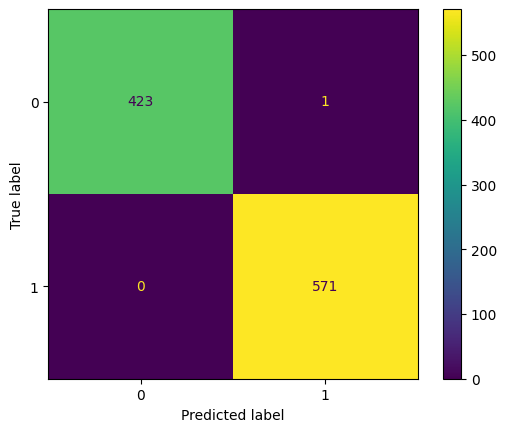

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       424
           1       1.00      1.00      1.00       571

    accuracy                           1.00       995
   macro avg       1.00      1.00      1.00       995
weighted avg       1.00      1.00      1.00       995



In [72]:
## cf. confusion matrix 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# rfc 모델로 x_test를 예측한 값을 y_pred로 저장하기
y_pred = rfc.predict(x_test) 

# 실제값 le_y_test(레이블 인코딩을 해야 0,1로 표현됨)와 예측값 y_pred 비교하기
cm = confusion_matrix(le_y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()

# 오차행렬(Confusion Matrix) 출력하기
plt.show() 

# 오차행렬(Confusion Matrix)를 통한 각종 지표들을 리포트로 출력하기
print(classification_report(le_y_test, y_pred)) 